# 

In [1]:

from dataclasses import asdict, dataclass
from functools import lru_cache
from typing import Any

import ipywidgets as W
import numpy as np
from IPython.display import display
from smef.core.units import Q
from smef.engine import SimulationEngine, UnitSystem

from bec.metrics.metrics import QDDiagnostics
from bec.quantum_dot.dot import QuantumDot
from bec.quantum_dot.enums import QDState
from bec.quantum_dot.smef.initial_state import rho0_qd_vacuum
from bec.quantum_dot.spec.cavity_params import CavityParams
from bec.quantum_dot.spec.dipole_params import DipoleParams
from bec.quantum_dot.spec.energy_structure import EnergyStructure
from bec.reporting.plotting.api import plot_run
from bec.scenarios.factories import SchemeKind, get_scheme_factory

In [2]:
def make_qd() -> QuantumDot:
    exciton = Q(1.300, "eV")
    binding = Q(3.0e-3, "eV")
    fss = Q(5.0e-6, "eV")

    energy = EnergyStructure.from_params(
        exciton=exciton,
        binding=binding,
        fss=fss,
    )

    dipoles = DipoleParams.biexciton_cascade_from_fss(
        mu_default_Cm=Q(10.0 * 3.33564e-30, "C*m"),
        fss=fss,
    )

    cavity = CavityParams.from_values(
        Q=5.0e4,
        Veff_um3=0.5,
        lambda_nm=930.0,
        n=3.4,
    )

    return QuantumDot(
        energy=energy,
        dipoles=dipoles,
        cavity=cavity,
        phonons=None,
    )
    
@dataclass(frozen=True)
class RunCfg:
    t_end_ns: float = 1.0
    n_points: int = 2001
    t0_ns: float = 0.5
    sigma_ns: float = 0.03
    compensate_polaron: bool = False
    label_prefix: str = "qd"

def make_units_tlist_time_unit(
    cfg: RunCfg,
) -> tuple[UnitSystem, np.ndarray, float]:
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    tlist = np.linspace(0.0, float(cfg.t_end_ns), int(cfg.n_points))
    return units, tlist, time_unit_s


def make_rho0(qd: QuantumDot, units: UnitSystem) -> np.ndarray:
    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    return rho0_qd_vacuum(dims=dims, qd_state=QDState.G)
_SOLVE_OPTIONS = {
    "qutip_options": {
        "method": "bdf",
        "atol": 1e-10,
        "rtol": 1e-8,
        "nsteps": 200000,
        "max_step": 0.01,
        "progress_bar": "tqdm",
    }
}



In [3]:
def run_scheme(
    *,
    qd: QuantumDot,
    cfg: RunCfg,
    scheme: SchemeKind,
    tlist: np.ndarray,
    time_unit_s: float,
    amp_scale: float = 1.0,
    detuning_offset_rad_s: float = 0.0,
    scheme_kwargs: dict[str, Any] | None = None,
    audit: bool = True,
) -> tuple[Any, list[Any]]:
    if scheme_kwargs is None:
        scheme_kwargs = {}

    factory = get_scheme_factory(scheme)
    specs, payloads = factory(
        qd,
        cfg=cfg,
        amp_scale=float(amp_scale),
        detuning_offset_rad_s=float(detuning_offset_rad_s),
        label=f"{cfg.label_prefix}_{scheme.name.lower()}",
        **scheme_kwargs,
    )

    units = UnitSystem(time_unit_s=float(time_unit_s))
    rho0 = make_rho0(qd, units)

    engine = SimulationEngine(audit=bool(audit))
    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=float(time_unit_s),
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )
    return res, list(payloads)

In [4]:
bichromatic_kwargs = {
    "dt_ns": -0.020,
    "sigma_gx_ns": 0.06,
    "sigma_xx_ns": 0.08,
    "dpe_delta_rad_s": 7.0e10,  # example
    # "dpe_delta_rad_s": 0.0e10,  # example
}

In [5]:
cfg = RunCfg(
    t_end_ns=1.0,
    n_points=2001,
    t0_ns=0.3,
    sigma_ns=0.03,
    compensate_polaron=False,
    label_prefix="qd",
)
    
units, tlist, time_unit_s = make_units_tlist_time_unit(cfg)

qd = make_qd()
res, payloads = run_scheme(
    qd=qd,
    cfg=cfg,
    scheme=SchemeKind.BICHROMATIC,
    tlist=tlist,
    time_unit_s=time_unit_s,
    amp_scale=4.3,
    detuning_offset_rad_s=0,
    scheme_kwargs=bichromatic_kwargs,
    audit=True,
)

metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())

chosen_final: [('G<->X1', '1ph', 0.9999999999999999, 70000000000.0, 70000000000.0)]
chosen_final: [('X1<->XX', '1ph', 0.9999999999999999, 70000000000.0, 70000000000.0)]
{'dims': (4, 2, 2, 2, 2), 'D': 64, 'tlist_N': 2001, 'tlist_range': (0.0, 1.0), 'dt_min': 0.0004999999999999449, 'dt_max': 0.000500000000000056, 'rho0_shape': (64, 64), 'H': {'count': 7, 'terms': [{'index': 0, 'label': 'H_exciton_fss_mix', 'op_shape': (64, 64), 'op_fro_norm': 21.485686308970415, 'op_hermitian_max_abs_err': 0.0, 'op_is_hermitian': True, 'coeff_min_abs': 1.0, 'coeff_max_abs': 1.0, 'coeff_peak_index': 0, 'coeff_peak_t': 0.0, 'coeff_peak_val': (1+0j), 'coeff_area': (1+0j), 'op_top_entries': [(3.7981686218799866, (39, 39), (-3.7981686218799866+0j)), (3.7981686218799866, (37, 37), (-3.7981686218799866+0j)), (3.7981686218799866, (41, 41), (-3.7981686218799866+0j)), (3.7981686218799866, (23, 23), (3.7981686218799866+0j)), (3.7981686218799866, (36, 36), (-3.7981686218799866+0j)), (3.7981686218799866, (34, 34), (-

  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 9.05649e-17
Min eigenvalue      : -9.57852e-09

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.9285
 X1 : 0.0543665
 X2 : 0.0151204
 XX : 0.00201319

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.0508269
p1_total  : 0.100605
p2_exact  : 0.752455

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.11308
p1_total  : 0.819787
p2_exact  : 0.0671331

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.0909391
p1_total  : 0.848589
p2_exact  : 0.0604717

PHOTON NUMBER EXPECTATION VALUES
------------------------------------

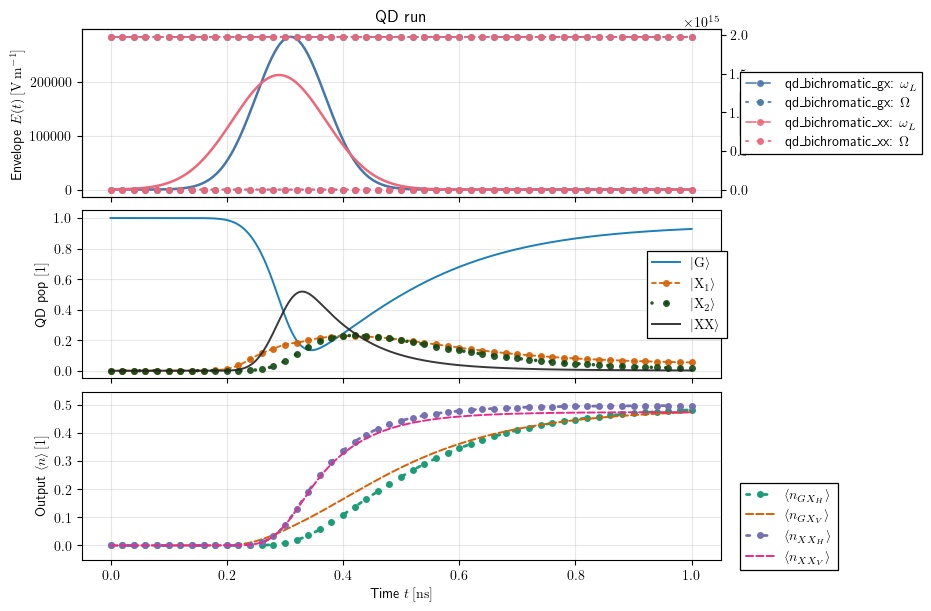

In [6]:
plot_run(res, units=units, drives=[p for p in payloads], qd=qd);


In [7]:


# ----------------------------
# 1) Parameter container
# ----------------------------
@dataclass(frozen=True)
class StirapParams:
    # time grid
    t_end_ns: float = 1.0
    n_points: int = 2001

    # pulse geometry
    t0_ns: float = 0.3
    dt_ns: float = -0.02
    sigma_gx_ns: float = 0.06
    sigma_xx_ns: float = 0.08

    # drive parameters
    amp_scale: float = 4.0
    dpe_delta_rad_s: float = 5.0e10
    rel_phase_rad: float = 0.0
    detuning_offset_rad_s: float = 0.0

    compensate_polaron: bool = False

    # plotting/solve toggles
    audit: bool = False


def make_cfg_from_params(p: StirapParams) -> "RunCfg":
    return RunCfg(
        t_end_ns=float(p.t_end_ns),
        n_points=int(p.n_points),
        t0_ns=float(p.t0_ns),
        sigma_ns=float(min(p.sigma_gx_ns, p.sigma_xx_ns)),  # not used by bichro, but keep sane
        compensate_polaron=bool(p.compensate_polaron),
        label_prefix="qd",
    )


# ----------------------------
# 2) Cache the expensive run
# ----------------------------
@lru_cache(maxsize=64)
def run_bichromatic_cached(p: StirapParams):
    qd = make_qd()
    cfg = make_cfg_from_params(p)
    units, tlist, time_unit_s = make_units_tlist_time_unit(cfg)

    bichromatic_kwargs = {
        "dt_ns": float(p.dt_ns),
        "sigma_gx_ns": float(p.sigma_gx_ns),
        "sigma_xx_ns": float(p.sigma_xx_ns),
        "dpe_delta_rad_s": float(p.dpe_delta_rad_s),
        "rel_phase_rad": float(p.rel_phase_rad),
    }

    res, payloads = run_scheme(
        qd=qd,
        cfg=cfg,
        scheme=SchemeKind.BICHROMATIC,
        tlist=tlist,
        time_unit_s=time_unit_s,
        amp_scale=float(p.amp_scale),
        detuning_offset_rad_s=float(p.detuning_offset_rad_s),
        scheme_kwargs=bichromatic_kwargs,
        audit=bool(p.audit),
    )
    return qd, units, tlist, res, payloads







# ----------------------------
# 5) UI Widgets
# ----------------------------
w_t_end = W.FloatSlider(value=1.5, min=0.2, max=5.0, step=0.1, description="t_end_ns", continuous_update=False)
w_npts = W.IntSlider(value=2001, min=501, max=8001, step=500, description="n_points", continuous_update=False)

w_t0 = W.FloatSlider(value=0.3, min=0.05, max=2.0, step=0.01, description="t0_ns", continuous_update=False)
w_dt = W.FloatSlider(value=-0.04, min=-0.5, max=0.5, step=0.001, description="dt_ns", continuous_update=False)

w_sig_gx = W.FloatSlider(value=0.03, min=0.005, max=0.5, step=0.005, description="sigma_gx", continuous_update=False)
w_sig_xx = W.FloatSlider(value=0.03, min=0.005, max=0.5, step=0.005, description="sigma_xx", continuous_update=False)

w_amp = W.FloatSlider(value=10.0, min=0.1, max=20.0, step=0.1, description="amp_scale", continuous_update=False)

# Detuning is huge; better as a log slider
w_dpe = W.FloatLogSlider(value=1.28e11, base=10, min=9, max=12, step=0.05, description="dpe_delta", continuous_update=False)

w_phase = W.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.05, description="rel_phase", continuous_update=False)

w_det_off = W.FloatLogSlider(value=1e0, base=10, min=-3, max=12, step=0.1, description="det_off", continuous_update=False)
w_det_off_enable = W.Checkbox(value=False, description="use detuning_offset")

w_polaron = W.Checkbox(value=False, description="compensate_polaron")
w_audit = W.Checkbox(value=False, description="audit")

btn_run = W.Button(description="Run", button_style="primary")
btn_clear_cache = W.Button(description="Clear cache")
out = W.Output()


def current_params():
    det_off = float(w_det_off.value) if w_det_off_enable.value else 0.0
    return StirapParams(
        t_end_ns=float(w_t_end.value),
        n_points=int(w_npts.value),
        t0_ns=float(w_t0.value),
        dt_ns=float(w_dt.value),
        sigma_gx_ns=float(w_sig_gx.value),
        sigma_xx_ns=float(w_sig_xx.value),
        amp_scale=float(w_amp.value),
        dpe_delta_rad_s=float(w_dpe.value),
        rel_phase_rad=float(w_phase.value),
        detuning_offset_rad_s=float(det_off),
        compensate_polaron=bool(w_polaron.value),
        audit=bool(w_audit.value),
    )



def on_run(_):
    p = current_params()
    with out:
        out.clear_output(wait=True)
        print("Params:", asdict(p))

        qd, units, tlist, res, drives = run_bichromatic_cached(p)

        fig = plot_run(
            res,
            units=units,
            drives=drives,
            qd=qd,
        )

        if fig is not None:
            display(fig)


def on_clear_cache(_):
    run_bichromatic_cached.cache_clear()
    with out:
        print("Cache cleared.")


btn_run.on_click(on_run)
btn_clear_cache.on_click(on_clear_cache)

ui = W.VBox([
    W.HBox([btn_run, btn_clear_cache]),
    W.HBox([w_t_end, w_npts]),
    W.HBox([w_t0, w_dt]),
    W.HBox([w_sig_gx, w_sig_xx]),
    W.HBox([w_amp, w_dpe]),
    W.HBox([w_phase, w_det_off_enable, w_det_off]),
    W.HBox([w_polaron, w_audit]),
])

display(ui, out)


Output()

In [11]:
import ipywidgets as W

b = W.Button(description="click me")
out = W.Output()

def f(_):
    with out:
        print("clicked")

b.on_click(f)
display(b, out)



Button(description='click me', style=ButtonStyle())

Output()